In [18]:
import torch
import sys
import pathlib 
import joblib
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from betavae import BetaVAE, train_vae, evaluate_vae

In [19]:
# Load data
output_dir = pathlib.Path("data")

sys.path.insert(0, "../0.data-download/scripts/")
from data_loader import load_train_test_data

data_directory = pathlib.Path("../0.data-download/data")
train_data, test_data, val_data, load_gene_stats = load_train_test_data(data_directory, train_or_test="all", load_gene_stats=True)



# Convert data to tensors
train_tensor = torch.tensor(train_data)
test_tensor = torch.tensor(test_data)
val_tensor = torch.tensor(val_data)


In [20]:
# Load best hyperparameters
best_hyperparams = {
    'latent_dim': 21,
    'beta': 1.0098845974982587,
    'learning_rate': 0.001,
    'batch_size': 48,
    'epochs': 505
}

latent_dim = best_hyperparams['latent_dim']
beta = best_hyperparams['beta']
learning_rate = best_hyperparams['learning_rate']
batch_size = best_hyperparams['batch_size']
epochs = best_hyperparams['epochs']

train_loader = DataLoader(TensorDataset(train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(test_tensor), batch_size=batch_size, shuffle=False)
val_loader = DataLoader(TensorDataset(val_tensor), batch_size=batch_size, shuffle=False)

In [29]:
# Initialize and train the model, log training loss
model = BetaVAE(input_dim=train_data.shape[1], latent_dim=latent_dim, beta=beta)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loss_history = []

train_loss = train_vae(model, train_loader, optimizer, epochs)
train_loss_history.append(train_loss)

val_loss_history = []

test_loss = train_vae(model, val_loader, optimizer, epochs)
val_loss_history.append(test_loss)


TypeError: 'range' object cannot be interpreted as an integer

In [25]:
# Evaluate the model and log test loss 
val_loss_history = []
for epoch in range(epochs):
    val_loss = evaluate_vae(model, val_loader)
    val_loss_history.append(val_loss)
    print(f'Test Loss: {val_loss}')

# Save the model
model_path = pathlib.Path("results/best_vae_model.pth")
torch.save(model.state_dict(), model_path)

# Save training history (if any)
history = {
    'loss' : train_loss_history,
    'val_loss': val_loss_history
}

history_path = pathlib.Path("results/training_history.json")
with open(history_path, 'w') as f:
    json.dump(history, f)

Test Loss: 2184.387362995825
Test Loss: 2184.8080310542796
Test Loss: 2183.4852231210857
Test Loss: 2184.1044983037577
Test Loss: 2183.887754436326
Test Loss: 2183.537088987474
Test Loss: 2183.7447318632567
Test Loss: 2184.1122129436326
Test Loss: 2183.9924973903967
Test Loss: 2183.9701037317327
Test Loss: 2184.7024236691022
Test Loss: 2185.282881002088
Test Loss: 2184.6136645354904
Test Loss: 2183.494161012526
Test Loss: 2184.8951918058456
Test Loss: 2184.4611495302715
Test Loss: 2184.299386743215
Test Loss: 2184.0751891962423
Test Loss: 2183.806383742171
Test Loss: 2185.902188804802
Test Loss: 2183.9862669624217
Test Loss: 2184.9706908924845
Test Loss: 2183.923897442589
Test Loss: 2182.7361364822546
Test Loss: 2183.527433455115
Test Loss: 2185.4113387265133
Test Loss: 2183.6478666492694
Test Loss: 2183.7655434498956
Test Loss: 2183.2363322025053
Test Loss: 2183.5062467379958
Test Loss: 2185.2990768528184
Test Loss: 2185.570051539666
Test Loss: 2184.852100730689
Test Loss: 2185.334534

In [23]:
# Save latent space
model.eval()
with torch.no_grad():
    latent_space = model.encoder(train_tensor)[0].numpy()
    latent_df = pd.DataFrame(latent_space)
    latent_df.to_csv("results/latent_space.csv", index=False)

ValueError: x and y must have same first dimension, but have shapes (1,) and (505,)

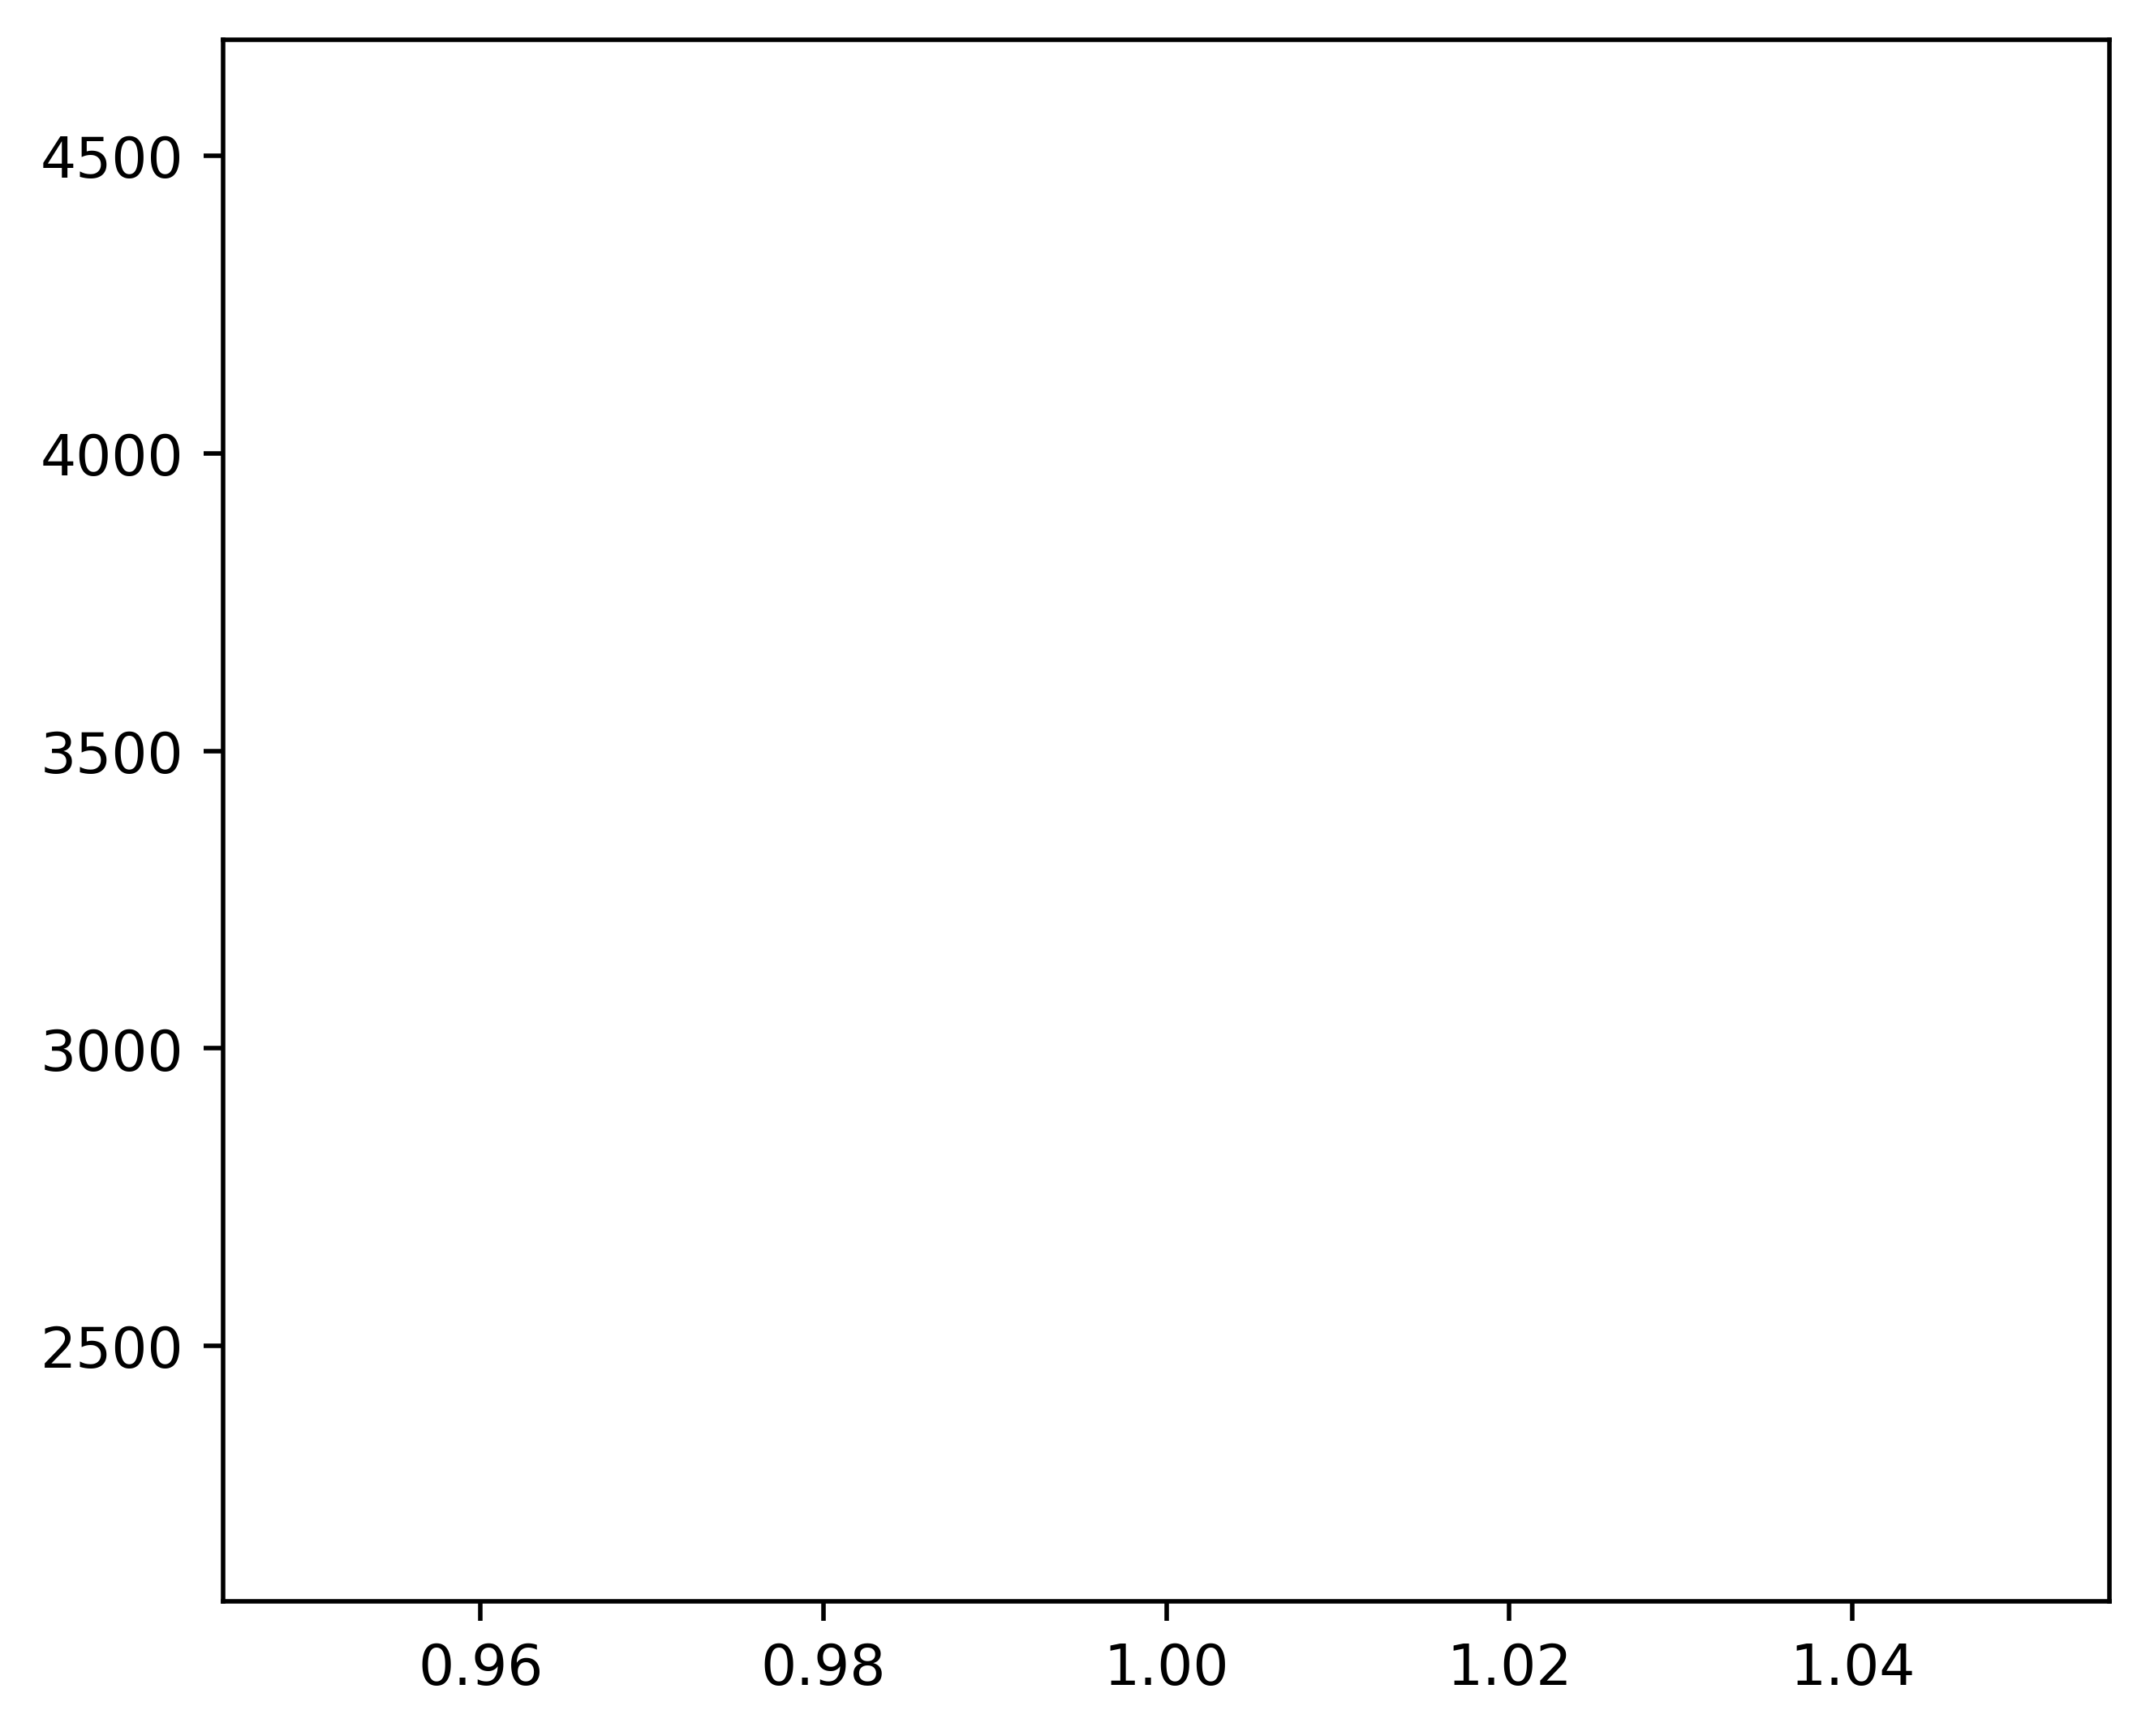

In [26]:
# Load the training history
history_path = pathlib.Path("results/training_history.json")
with open(history_path, 'r') as f:
    history = json.load(f)

train_loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(train_loss) + 1)

#Plot training and testing curves and save the figure
save_path = pathlib.Path("../1.data-exploration/figures/training_curve.png")

plt.figure(figsize=(6, 5), dpi=500)
plt.plot(epochs, train_loss, label='Training Data')
plt.plot(epochs, val_loss, label='Testing Data')
plt.xlabel('Epochs')
plt.ylabel('MSE + KL Divergence')
plt.yscale('log')
plt.title('Training vs Testing Loss')
plt.legend()
plt.savefig(save_path)
plt.show()